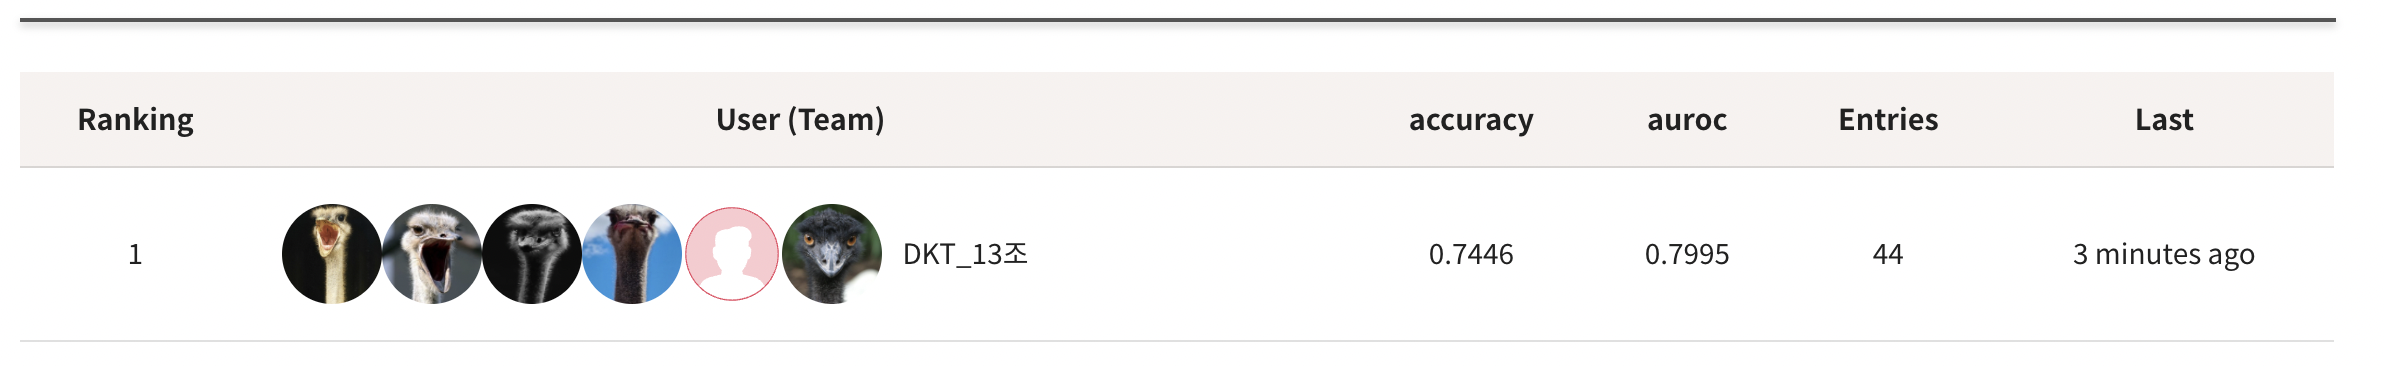

https://minimin2.tistory.com/137

https://leo-bb.tistory.com/62?category=858291

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.std.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -zxvf /content/drive/MyDrive/Colab_data/ai_boostcamp_data/p-stage-4-data/원본데이터/train_dataset.tar.gz

train_dataset/._sample_submission.csv
train_dataset/sample_submission.csv
train_dataset/._test_data.csv
train_dataset/test_data.csv
train_dataset/._train_data.csv
train_dataset/train_data.csv


In [ ]:
!pip install pycaret > /dev/null

ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.4.1 which is incompatible.
ERROR: pyldavis 3.3.1 has requirement numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: pyldavis 3.3.1 has requirement pandas>=1.2.0, but you'll have pandas 1.1.5 which is incompatible.


# LGBM with pycaret



In [ ]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from pycaret.classification import *
from pycaret.utils import check_metric
from datetime import timedelta, timezone, datetime

# 데이터 가져오기

In [ ]:
train_path = '/content/train_dataset/train_data.csv'
test_path = '/content/train_dataset/test_data.csv'
submission_path = '/content/train_dataset/sample_submission.csv'

In [ ]:
df_train_ori = pd.read_csv(train_path) 
df_test_ori = pd.read_csv(test_path)

answerCode2bool = {'userID':object,  'answerCode': 'int16', 'KnowledgeTag':object}
df_train_ori = df_train_ori.astype(answerCode2bool)
df_test_ori = df_test_ori.astype(answerCode2bool)
df_train_ori.Timestamp = pd.to_datetime(df_train_ori.Timestamp)
df_test_ori.Timestamp = pd.to_datetime(df_test_ori.Timestamp)

# EDA 여기에서 진행해주세요!

In [ ]:
df_train_ori.head(2)

userID assessmentItemID      testId  answerCode           Timestamp  \
0      0       A060001001  A060000001           1 2020-03-24 00:17:11   
1      0       A060001002  A060000001           1 2020-03-24 00:17:14   

  KnowledgeTag  
0         7224  
1         7225

#Feature Engineering

## 미리미리 만들어놔야 하는 피처가 있습니다.

In [ ]:
# trian에서 각 문제 평균 뽑기

testId_mean_sum = df_train_ori.groupby(['testId'])['answerCode'].agg(['mean','sum']).to_dict()
assessmentItemID_mean_sum = df_train_ori.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum']).to_dict()
KnowledgeTag_mean_sum = df_train_ori.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum']).to_dict()

assessmentItemID_mean_sum['mean']['A060001001']

In [ ]:
# 맞춰야하는 문항 ID 파악
set_assessmentItemID = set(df_test_ori.loc[df_test_ori.answerCode == -1, 'assessmentItemID'].values)

## 그때그때 만들어줘야 하는 피처가 있습니다.

In [ ]:
def feature_engineering(df):

    # 문항이 중간에 비어있는 경우를 파악 (1,2,3,,5)
    def assessmentItemID2item(x):
        return int(x[-3:]) - 1  # 0 부터 시작하도록 
    df['item'] = df.assessmentItemID.map(assessmentItemID2item)

    item_size = df[['assessmentItemID', 'testId']].drop_duplicates().groupby('testId').size()
    testId2maxlen = item_size.to_dict() # 중복해서 풀이할 놈들을 제거하기 위해

    item_max = df.groupby('testId').item.max()
    print(len(item_max[item_max + 1 != item_size]), '개의 시험지가 중간 문항이 빈다. item_order가 올바른 순서') # item_max는 0부터 시작하니까 + 1
    shit_index = item_max[item_max +1 != item_size].index
    shit_df = df.loc[df.testId.isin(shit_index),['assessmentItemID', 'testId']].drop_duplicates().sort_values('assessmentItemID')      
    shit_df_group = shit_df.groupby('testId')

    shitItemID2item = {}
    for key in shit_df_group.groups:
        for i, (k,_) in enumerate(shit_df_group.get_group(key).values):
            shitItemID2item[k] = i
        
    def assessmentItemID2item_order(x):
        if x in shitItemID2item:
            return int(shitItemID2item[x])
        return int(x[-3:]) - 1  # 0 부터 시작하도록 
    df['item_order'] =  df.assessmentItemID.map(assessmentItemID2item_order)



    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # 유저가 푼 시험지에 대해, 유저의 전체 정답/풀이횟수/정답률 계산 (3번 풀었으면 3배)
    df_group = df.groupby(['userID','testId'])['answerCode']
    df['user_total_correct_cnt'] = df_group.transform(lambda x: x.cumsum().shift(1))
    df['user_total_ans_cnt'] = df_group.cumcount()
    df['user_total_acc'] = df['user_total_correct_cnt'] / df['user_total_ans_cnt']

    # 유저가 푼 시험지에 대해, 유저의 풀이 순서 계산 (시험지를 반복해서 풀었어도, 누적되지 않음)
    # 특정 시험지를 얼마나 반복하여 풀었는지 계산 ( 2번 풀었다면, retest == 1)
    df['test_size'] = df.testId.map(testId2maxlen)
    df['retest'] = df['user_total_ans_cnt'] // df['test_size']
    df['user_test_ans_cnt'] = df['user_total_ans_cnt'] % df['test_size']

    # 각 시험지 당 유저의 정확도를 계산
    df['user_test_correct_cnt'] = df.groupby(['userID','testId','retest'])['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_acc'] = df['user_test_correct_cnt']/df['user_test_ans_cnt']


    # 아래의 피처는 다이나믹 합니다. 학습된 train의 평균값을 사용하지 않고, 새로 들어온 데이터의 평균 값을 사용합니다.
    # # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    # correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    # correct_t.columns = ["test_mean", 'test_sum']
    # correct_a = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
    # correct_a.columns = ["ItemID_mean", 'ItemID_sum']
    # correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    # correct_k.columns = ["tag_mean", 'tag_sum']
    # df = pd.merge(df, correct_t, on=['testId'], how="left")
    # df = pd.merge(df, correct_a, on=['assessmentItemID'], how="left")
    # df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")

    # 본 피처는 train에서 얻어진 값을 그대로 유지합니다.
    df["test_mean"] = df.testId.map(testId_mean_sum['mean'])
    df['test_sum'] = df.testId.map(testId_mean_sum['sum'])
    df["ItemID_mean"] = df.assessmentItemID.map(assessmentItemID_mean_sum['mean'])
    df['ItemID_sum'] = df.assessmentItemID.map(assessmentItemID_mean_sum['sum'])
    df["tag_mean"] = df.KnowledgeTag.map(KnowledgeTag_mean_sum['mean'])
    df['tag_sum'] = df.KnowledgeTag.map(KnowledgeTag_mean_sum['sum'])

    return df

In [ ]:
df_test = feature_engineering(df_test_ori)
df = feature_engineering(df_train_ori)
# 피처를 대충만들어서 꽤 오래걸립니다.

31 개의 시험지가 중간 문항이 빈다. item_order가 올바른 순서
31 개의 시험지가 중간 문항이 빈다. item_order가 올바른 순서


In [ ]:
df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)]

## 엔지니어링 이후의 EDA

In [ ]:
for i in range(14):
    order = df.loc[(df.item_order == df.user_test_ans_cnt) & (df.user_test_ans_cnt >= i),'answerCode'].mean()
    deorder = df.loc[(df.item_order != df.user_test_ans_cnt) & (df.user_test_ans_cnt >= i),'answerCode'].mean()
    print(order,deorder)

# 섞어서 풀면 인간의 성능이 항상 떨어진다고 생각했는데, 마지막 2놈은 아니었다.
# 그 와중에 뒤로 갈 수록 정답률 떨어지는건 신기하네

0.6624658036224673 0.5182486920262774
0.6439186285734882 0.5084225999391748
0.6232205172483117 0.4963426269479487
0.5989661078645218 0.48234143387789796
0.5637783249433571 0.4696193708709619
0.5268748949834774 0.4559906770157655
0.494829097283085 0.4438200261548793
0.4619607360452951 0.4351367459108668
0.48256888103462126 0.4208881945994198
0.4796472880139444 0.3949232585596222
0.4258128078817734 0.3718446601941748
0.34984789222077356 0.37168141592920356
0.20306513409961685 0.25
nan nan


In [ ]:
# 시험지를 여러번 푼 경우
# 이 친구 보면 알겠지만, 나중에 푼다고 잘 푸는건 아님
# 어짜피 2번째 푸는거면 직전 문제들도 어련히 잘 풀었겠지
df[(df.userID == 1069)  & (df.testId =='A080000127')] 

userID assessmentItemID      testId  ...  ItemID_sum  tag_mean tag_sum
740661   1069       A080127001  A080000127  ...         202  0.505427    1490
740662   1069       A080127002  A080000127  ...         176  0.505427    1490
740663   1069       A080127003  A080000127  ...         192  0.505427    1490
740664   1069       A080127004  A080000127  ...         144  0.470031    1537
740665   1069       A080127005  A080000127  ...         176  0.505427    1490
740666   1069       A080127006  A080000127  ...         203  0.470031    1537
740667   1069       A080127007  A080000127  ...         162  0.442564    1229
740668   1069       A080127008  A080000127  ...         136  0.470031    1537
740701   1069       A080127001  A080000127  ...         202  0.505427    1490
740702   1069       A080127002  A080000127  ...         176  0.505427    1490
740703   1069       A080127003  A080000127  ...         192  0.505427    1490
740704   1069       A080127004  A080000127  ...         144  0.470031    1537
740705   1069       A080127005  A080000127  ...         176  0.505427    1490
740706   1069       A080127006  A080000127  ...         203  0.470031    1537
740707   1069       A080127007  A080000127  ...         162  0.442564    1229
740708   1069       A080127008  A080000127  ...         136  0.470031    1537
740766   1069       A080127001  A080000127  ...         202  0.505427    1490
740767   1069       A080127002  A080000127  ...         176  0.505427    1490
740768   1069       A080127003  A080000127  ...         192  0.505427    1490
740769   1069       A080127004  A080000127  ...         144  0.470031    1537
740770   1069       A080127005  A080000127  ...         176  0.505427    1490
740771   1069       A080127006  A080000127  ...         203  0.470031    1537
740772   1069       A080127007  A080000127  ...         162  0.442564    1229
740773   1069       A080127008  A080000127  ...         136  0.470031    1537

[24 rows x 22 columns]

#train/vali 데이터 셋 분리

In [ ]:
def my_train_vali_split(df, filter_option = None, train_must_exist_leaderboard = False, ratio=0.5, seed = 23):
    random.seed(seed)
    # 리더보드와 동일 조건의 컬럼 수집
    vali_full = df[(df['userID'] != df['userID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))].copy()
    
    # 리더보드와 동일 조건의 컬럼을 나누기
    ratio_r = (1 - ratio)
    vali_1 = vali_full.sample(frac=ratio_r, random_state = seed) # ratio가 1이면, ratio_r이 0이 되어, vali_1에 아무것도 할당되지 않는다.
    vali_2 = vali_full.drop(vali_1.index)

    # vali에 포함된 유저 목록 확인하기
    vali_1_userID = set(vali_1.userID.values)
    vali_2_userID = set(vali_2.userID.values)
    
    # vali에 없는 유저들만 train으로 데려오기
    train_1 = df[ df['userID'].isin(vali_1_userID) == False ].copy()
    train_2 = df[ df['userID'].isin(vali_2_userID) == False ].copy()
    
    # 마지막 응답만 가져올지 여부
    if filter_option == '시험지마지막응답':
        train_1 = train_1[train_1['testId'] != train_1['testId'].shift(-1)].copy()
        train_2 = train_2[train_2['testId'] != train_2['testId'].shift(-1)].copy()
    if filter_option == '사용자마지막응답':
        train_1 = train_1[train_1['userID'] != train_1['userID'].shift(-1)].copy()
        train_2 = train_2[train_2['userID'] != train_2['userID'].shift(-1)].copy()

    # train도 리더보드에서 맞춰야하는 문제(444개 문제)만 볼지 여부
    if train_must_exist_leaderboard:
        train_1 = train_1[train_1.assessmentItemID.isin(set_assessmentItemID)].copy()
        train_2 = train_2[train_2.assessmentItemID.isin(set_assessmentItemID)].copy()
    
    return train_1, vali_1, train_2, vali_2 , vali_full

## 후보기능

In [ ]:
def my_train_vali_split2(df, filter_option = None, train_must_exist_leaderboard = False, vali='Full', ratio=0.5, seed = 23):
    random.seed(seed)
    # 리더보드와 동일 조건의 컬럼 수집을 포기했다. df.assessmentItemID.isin(set_assessmentItemID))
    vali_full = df[(df['userID'] != df['userID'].shift(-1))].copy()

    # 리더보드와 동일 조건의 컬럼을 나누기
    ratio_r = (1 - ratio)
    vali_1 = vali_full.sample(frac=ratio_r, random_state = seed) # ratio가 1이면, ratio_r이 0이 되어, vali_1에 아무것도 할당되지 않는다.
    vali_2 = vali_full.drop(vali_1.index)

    # vali에 포함된 유저 목록 확인하기
    vali_1_userID = set(vali_1.userID.values)
    vali_2_userID = set(vali_2.userID.values)
    #vali_full_userID = set(vali_full.userID.values)

    # vali 유저의 전 기록을 쓸 경우, 디폴트는 마지막 응답만 사용합니다.
    if vali in ['Full', '시험지마지막응답']:
        vali_1 = df[ df['userID'].isin(vali_1_userID) == True ].copy()
        vali_2 = df[ df['userID'].isin(vali_2_userID) == True ].copy()
        #vali_full = df[ df['userID'].isin(vali_full_userID) == True ].copy()

    # vali 유저의 각 시험지 기록을 쓸 경우
    if vali == '시험지마지막응답': 
        vali_1 = vali_1[(vali_1['testId'] != vali_1['testId'].shift(-1))].copy()
        vali_2 = vali_2[(vali_2['testId'] != vali_2['testId'].shift(-1))].copy()
        #vali_full = df[ df['userID'].isin(vali_full_userID) == True ].copy()
        #vali_full = vali_full[(vali_full['testId'] != vali_full['testId'].shift(-1))].copy()

    # vali에 없는 유저들만 train으로 데려오기
    train_1 = df[ df['userID'].isin(vali_1_userID) == False ].copy()
    train_2 = df[ df['userID'].isin(vali_2_userID) == False ].copy()
    
    # 마지막 응답만 가져올지 여부
    if filter_option == '시험지마지막응답':
        train_1 = train_1[train_1['testId'] != train_1['testId'].shift(-1)].copy()
        train_2 = train_2[train_2['testId'] != train_2['testId'].shift(-1)].copy()
    if filter_option == '사용자마지막응답':
        train_1 = train_1[train_1['userID'] != train_1['userID'].shift(-1)].copy()
        train_2 = train_2[train_2['userID'] != train_2['userID'].shift(-1)].copy()

    # train도 리더보드에서 맞춰야하는 문제(444개 문제)만 볼지 여부
    if train_must_exist_leaderboard:
        train_1 = train_1[train_1.assessmentItemID.isin(set_assessmentItemID)].copy()
        train_2 = train_2[train_2.assessmentItemID.isin(set_assessmentItemID)].copy()
    
    return train_1, vali_1, train_2, vali_2 , vali_full

In [ ]:
def test_train_vali_split(df, filter_option = None, train_must_exist_leaderboard = False, vali='Full', ratio=0.5, seed = 23):
    random.seed(seed)
    # 리더보드와 동일 조건의 컬럼 수집을 포기했다.
    df = df[df.answerCode != -1].copy()
    vali_full = df[(df['userID'] != df['userID'].shift(-1))].copy()

    # 리더보드와 동일 조건의 컬럼을 나누기
    ratio_r = (1 - ratio)
    vali_1 = vali_full.sample(frac=ratio_r, random_state = seed) # ratio가 1이면, ratio_r이 0이 되어, vali_1에 아무것도 할당되지 않는다.
    vali_2 = vali_full.drop(vali_1.index)

    # vali에 포함된 유저 목록 확인하기
    vali_1_userID = set(vali_1.userID.values)
    vali_2_userID = set(vali_2.userID.values)
    #vali_full_userID = set(vali_full.userID.values)

    # vali 유저의 전 기록을 쓸 경우, 디폴트는 마지막 응답만 사용합니다.
    if vali in ['Full', '시험지마지막응답']:
        vali_1 = df[ df['userID'].isin(vali_1_userID) == True ].copy()
        vali_2 = df[ df['userID'].isin(vali_2_userID) == True ].copy()
        #vali_full = df[ df['userID'].isin(vali_full_userID) == True ].copy()

    # vali 유저의 각 시험지 마지막 기록을 쓸 경우
    if vali == '시험지마지막응답': 
        vali_1 = vali_1[(vali_1['testId'] != vali_1['testId'].shift(-1))].copy()
        vali_2 = vali_2[(vali_2['testId'] != vali_2['testId'].shift(-1))].copy()
        #vali_full = df[ df['userID'].isin(vali_full_userID) == True ].copy()
        #vali_full = vali_full[(vali_full['testId'] != vali_full['testId'].shift(-1))].copy()

    # vali에 없는 유저들만 train으로 데려오기
    train_1 = df[ df['userID'].isin(vali_1_userID) == False ].copy()
    train_2 = df[ df['userID'].isin(vali_2_userID) == False ].copy()
    
    # 마지막 응답만 가져올지 여부
    if filter_option == '시험지마지막응답':
        train_1 = train_1[train_1['testId'] != train_1['testId'].shift(-1)].copy()
        train_2 = train_2[train_2['testId'] != train_2['testId'].shift(-1)].copy()
    if filter_option == '사용자마지막응답':
        train_1 = train_1[train_1['userID'] != train_1['userID'].shift(-1)].copy()
        train_2 = train_2[train_2['userID'] != train_2['userID'].shift(-1)].copy()

    # train도 리더보드에서 맞춰야하는 문제(444개 문제)만 볼지 여부
    if train_must_exist_leaderboard:
        train_1 = train_1[train_1.assessmentItemID.isin(set_assessmentItemID)].copy()
        train_2 = train_2[train_2.assessmentItemID.isin(set_assessmentItemID)].copy()
    
    return train_1, vali_1, train_2, vali_2 , vali_full

# LGBM으로 실험 함수

In [ ]:
def exam_LGBM1( datasets ,FEATS, categorical_features=[],numeric_features=[],seed=47):
    train_1, vali_1, train_2, vali_2, vali_full = datasets
    random.seed(seed)
    settings = setup(data=train_1[FEATS], target='answerCode', train_size=0.8, categorical_features=categorical_features, numeric_features=numeric_features)
    
    lgbm = create_model('lightgbm', sort='AUC')
    tuned_lgbm = tune_model(lgbm, optimize = 'AUC', fold = 10)
    final_lgbm = finalize_model(tuned_lgbm)

    predict_model(lgbm)
    predict_model(tuned_lgbm)
    predict_model(final_lgbm)

    log = []
    prediction = predict_model(final_lgbm, data=vali_1[FEATS], raw_score = True)
    log.append(f"학습에 사용안한 데이터: {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
    prediction = predict_model(final_lgbm, data=vali_2[FEATS], raw_score = True)
    log.append(f"학습에 사용한 데이터:  {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
    prediction = predict_model(final_lgbm, data=vali_full[FEATS], raw_score = True)
    log.append(f"모든 vali 데이터:    {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
        
    return final_lgbm, log

In [ ]:
def exam_LGBM2( datasets ,FEATS, categorical_features=[],numeric_features=[],seed=47):
    train_1, vali_1, train_2, vali_2, vali_full = datasets
    random.seed(seed)
    settings = setup(data=train_2[FEATS], target='answerCode', train_size=0.8, categorical_features=categorical_features, numeric_features=numeric_features)
    
    lgbm = create_model('lightgbm', sort='AUC')
    tuned_lgbm = tune_model(lgbm, optimize = 'AUC', fold = 10)
    final_lgbm = finalize_model(tuned_lgbm)
    
    predict_model(lgbm)
    predict_model(tuned_lgbm)
    predict_model(final_lgbm)
    
    log = []
    prediction = predict_model(final_lgbm, data=vali_2[FEATS], raw_score = True)
    log.append(f"학습에 사용안한 데이터: {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
    prediction = predict_model(final_lgbm, data=vali_1[FEATS], raw_score = True)
    log.append(f"학습에 사용한 데이터:  {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
    prediction = predict_model(final_lgbm, data=vali_full[FEATS], raw_score = True)
    log.append(f"모든 vali 데이터:    {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")    
    
    return final_lgbm, log

In [ ]:
def exam_full(datasets ,FEATS, categorical_features=[],numeric_features=[],seed=47):
    train_1, vali_1, train_2, vali_2, vali_full = datasets
    random.seed(seed)
    settings = setup(data=train_1[FEATS], target='answerCode', train_size=0.8, categorical_features=categorical_features, numeric_features=numeric_features)
    
    lgbm = create_model('lightgbm', sort='AUC')
    tuned_lgbm = tune_model(lgbm, optimize = 'AUC', fold = 10)
    final_lgbm = finalize_model(tuned_lgbm)

    predict_model(lgbm)
    predict_model(tuned_lgbm)
    predict_model(final_lgbm)

    log = []
    prediction = predict_model(final_lgbm, data=vali_full[FEATS], raw_score = True)
    log.append(f"모든 vali 데이터:    {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
    return final_lgbm, log

# 절반 나눈 데이터로 실험

In [ ]:
filter_option = '시험지마지막응답' # 시험지마지막응답, 사용자마지막응답, None
train_must_exist_leaderboard = False # True, False

FEATS = ['user_acc','ItemID_mean','answerCode']
FEATS += ['test_mean']

categorical_features = []
#categorical_features += ['KnowledgeTag']

numeric_features = []
numeric_features += []

In [ ]:
df.columns # FEATS 참고용

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'item', 'item_order', 'user_total_correct_cnt',
       'user_total_ans_cnt', 'user_total_acc', 'test_size', 'retest',
       'user_test_ans_cnt', 'user_test_correct_cnt', 'user_acc', 'test_mean',
       'test_sum', 'ItemID_mean', 'ItemID_sum', 'tag_mean', 'tag_sum'],
      dtype='object')

In [ ]:
datasets = my_train_vali_split(df, filter_option = filter_option, train_must_exist_leaderboard = train_must_exist_leaderboard)
datasets_full = my_train_vali_split(df, filter_option = filter_option, train_must_exist_leaderboard = train_must_exist_leaderboard, ratio = 1.0) # 어떤 시드를 주던 영향 안받음.

print(len(datasets[0]), len(datasets[1]))
print(len(datasets[2]), len(datasets[3]))
print(len(datasets[4]), '\n')
print(datasets[0].answerCode.mean(),datasets[1].answerCode.mean())
print(datasets[2].answerCode.mean(),datasets[3].answerCode.mean())
print(datasets[4].answerCode.mean(), '\n')
print(len(datasets_full[0]), len(datasets_full[4]))
print(datasets_full[0].answerCode.mean(), datasets_full[4].answerCode.mean())

252727 2183
256662 2183
4366 

0.5599045610480875 0.48282180485570314
0.5571919489445263 0.48236371965185526
0.48259276225377923 

374594 4366
0.5601958386946935 0.48259276225377923


In [ ]:
# datasets = my_train_vali_split2(df, filter_option = filter_option, train_must_exist_leaderboard = train_must_exist_leaderboard, vali = '시험지마지막응답',  ratio = 0.5)
# datasets_full = my_train_vali_split2(df, filter_option = filter_option, train_must_exist_leaderboard = train_must_exist_leaderboard, vali = '시험지마지막응답', ratio =1.0) # 어떤 시드를 주던 영향 안받음.

# print(len(datasets[0]), len(datasets[1]))
# print(len(datasets[2]), len(datasets[3]))
# print(len(datasets[4]), '\n')
# print(datasets[0].answerCode.mean(),datasets[1].answerCode.mean())
# print(datasets[2].answerCode.mean(),datasets[3].answerCode.mean())
# print(datasets[4].answerCode.mean(), '\n')
# print(len(datasets_full[0]), len(datasets_full[4]))
# print(datasets_full[0].answerCode.mean(), datasets_full[4].answerCode.mean())

In [ ]:
# datasets = test_train_vali_split(df_test, filter_option = filter_option, train_must_exist_leaderboard = train_must_exist_leaderboard, vali = None,  ratio = 0.5)
# datasets_full = test_train_vali_split(df_test, filter_option = filter_option, train_must_exist_leaderboard = train_must_exist_leaderboard, vali = None, ratio =1.0) # 어떤 시드를 주던 영향 안받음.

# print(len(datasets[0]), len(datasets[1]))
# print(len(datasets[2]), len(datasets[3]))
# print(len(datasets[4]), '\n')
# print(datasets[0].answerCode.mean(),datasets[1].answerCode.mean())
# print(datasets[2].answerCode.mean(),datasets[3].answerCode.mean())
# print(datasets[4].answerCode.mean(), '\n')
# print(len(datasets_full[0]), len(datasets_full[4]))
# print(datasets_full[0].answerCode.mean(), datasets_full[4].answerCode.mean())

In [ ]:
model1,log1 = exam_LGBM1(datasets ,FEATS, categorical_features, numeric_features)
model2,log2 = exam_LGBM2(datasets ,FEATS, categorical_features, numeric_features)
model_full,log_full = exam_full(datasets_full ,FEATS, categorical_features, numeric_features)

print('\n',model1)
print(model2)
print(model_full)
print(f'\n폴드1:')
print('\n'.join(log1))
print(f'\n폴드2:')
print('\n'.join(log2))
print(f'\n전부넣기:')
print('\n'.join(log_full))

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7492  0.8183  0.8174  0.7550  0.7850  0.4852  0.4874
1       0.7551  0.8229  0.8254  0.7586  0.7906  0.4970  0.4996
2       0.7498  0.8177  0.8152  0.7569  0.7849  0.4869  0.4889
3       0.7496  0.8207  0.8161  0.7561  0.7850  0.4863  0.4883
4       0.7507  0.8247  0.8121  0.7595  0.7849  0.4893  0.4909
5       0.7502  0.8202  0.8145  0.7577  0.7850  0.4878  0.4896
6       0.7505  0.8185  0.8139  0.7583  0.7851  0.4885  0.4902
7       0.7475  0.8198  0.8136  0.7547  0.7830  0.4821  0.4840
8       0.7501  0.8188  0.8146  0.7575  0.7850  0.4877  0.4895
9       0.7460  0.8158  0.8136  0.7528  0.7820  0.4787  0.4808
Mean    0.7499  0.8197  0.8156  0.7567  0.7851  0.4870  0.4889
SD      0.0022  0.0024  0.0035  0.0020  0.0021  0.0045  0.0046

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Light Gradient Boosting Machine    0.7478  0.8175  ...  0.7829  0.4831  0.4847

[1 rows x 8 columns]

Model  Accuracy     AUC  ...      F1  Kappa     MCC
0  Light Gradient Boosting Machine    0.7478  0.8172  ...  0.7829  0.483  0.4846

[1 rows x 8 columns]

Model  Accuracy     AUC  ...      F1   Kappa    MCC
0  Light Gradient Boosting Machine      0.75  0.8207  ...  0.7851  0.4872  0.489

[1 rows x 8 columns]


 LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_depth=-1,
               min_child_samples=46, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=190, n_jobs=-1, num_leaves=20, objective=None,
               random_state=5914, reg_alpha=3, reg_lambda=0.0005, silent=True,
               sort='AUC', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_depth=-1,
               min_child_samples=46, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=190, n_jobs=-1, num_leaves=20, objective=None,
               random_state=5914, reg_alpha=3, reg_lam



# Inference

In [ ]:
# MAKE PREDICTION
# SAVE OUTPUT

prediction = predict_model(model_full, data=df_test_shift[FEATS], raw_score=True)
total_preds = prediction.Score_1.values

prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

output_dir = '/content/drive/MyDrive/Colab_data/ai_boostcamp_data/p-stage-4-data/'
write_path = os.path.join(output_dir, f"{prediction_name}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

name = ('filter_option', 'train_must_exist_leaderboard', 'FEATS', 'log1', 'log2','log_full')
logs = (filter_option, train_must_exist_leaderboard, FEATS, log1, log2,log_full)
write_path = os.path.join(output_dir, f"{prediction_name}_log.txt")
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    for n, l in zip(name, logs):
        w.write(f'{n}: {l}\n')

writing prediction : /content/drive/MyDrive/Colab_data/ai_boostcamp_data/p-stage-4-data/0528_2319.csv
writing prediction : /content/drive/MyDrive/Colab_data/ai_boostcamp_data/p-stage-4-data/0528_2319_log.txt
